In [ ]:
!pip install langdetect


In [ ]:
# Import Libraries
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Reading both CSV files
tweets_biden = pd.read_csv('/content/drive/My Drive/Creatives/hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv('/content/drive/My Drive/Creatives/hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

# Clean country column
tweets_biden['country'] = tweets_biden['country'].replace({'United States': 'United States of America'})
tweets_trump['country'] = tweets_trump['country'].replace({'United States': 'United States of America'})

# Add Features
def normalise(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    sid = SentimentIntensityAnalyzer()
    temp = []
    for row in data:
        tmp = sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# Convert to datetime with error handling for mixed formats
tweets_biden['user_join_date'] = pd.to_datetime(tweets_biden['user_join_date'], errors='coerce')
tweets_trump['user_join_date'] = pd.to_datetime(tweets_trump['user_join_date'], errors='coerce')
tweets_biden['collected_at'] = pd.to_datetime(tweets_biden['collected_at'], errors='coerce')
tweets_trump['collected_at'] = pd.to_datetime(tweets_trump['collected_at'], errors='coerce')
tweets_biden['created_at'] = pd.to_datetime(tweets_biden['created_at'], errors='coerce')
tweets_trump['created_at'] = pd.to_datetime(tweets_trump['created_at'], errors='coerce')

# Create additional datetime columns
tweets_biden['created_at_r'] = tweets_biden['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r'] = tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden['created_at_r2'] = tweets_biden['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2'] = tweets_trump['created_at'].dt.strftime('%m-%d')

# Normalizing likes and retweets for fair analysis
tweets_biden['normalized_likes'] = normalise(tweets_biden['likes'], tweets_biden['likes'].sum())
tweets_trump['normalized_likes'] = normalise(tweets_trump['likes'], tweets_trump['likes'].sum())
tweets_biden['normalized_retweets'] = normalise(tweets_biden['retweet_count'], tweets_biden['retweet_count'].sum())
tweets_trump['normalized_retweets'] = normalise(tweets_trump['retweet_count'], tweets_trump['retweet_count'].sum())

# Proceed with further analysis...

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

<ipython-input-61-73aa48cb65c8>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



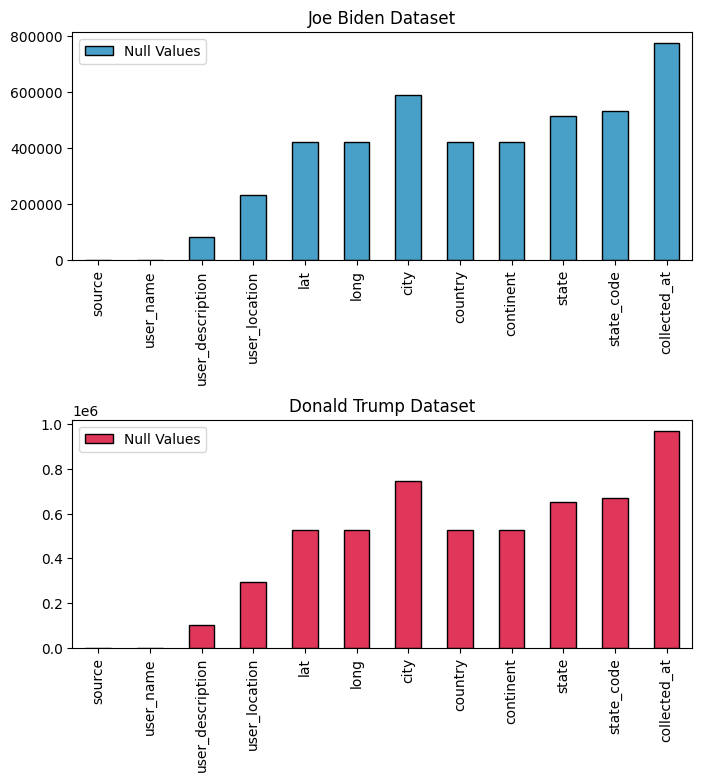

In [ ]:
na_vals_b=pd.DataFrame({'Null Values':tweets_biden.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]

# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(8,8), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

<ipython-input-63-9d4926d2539c>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





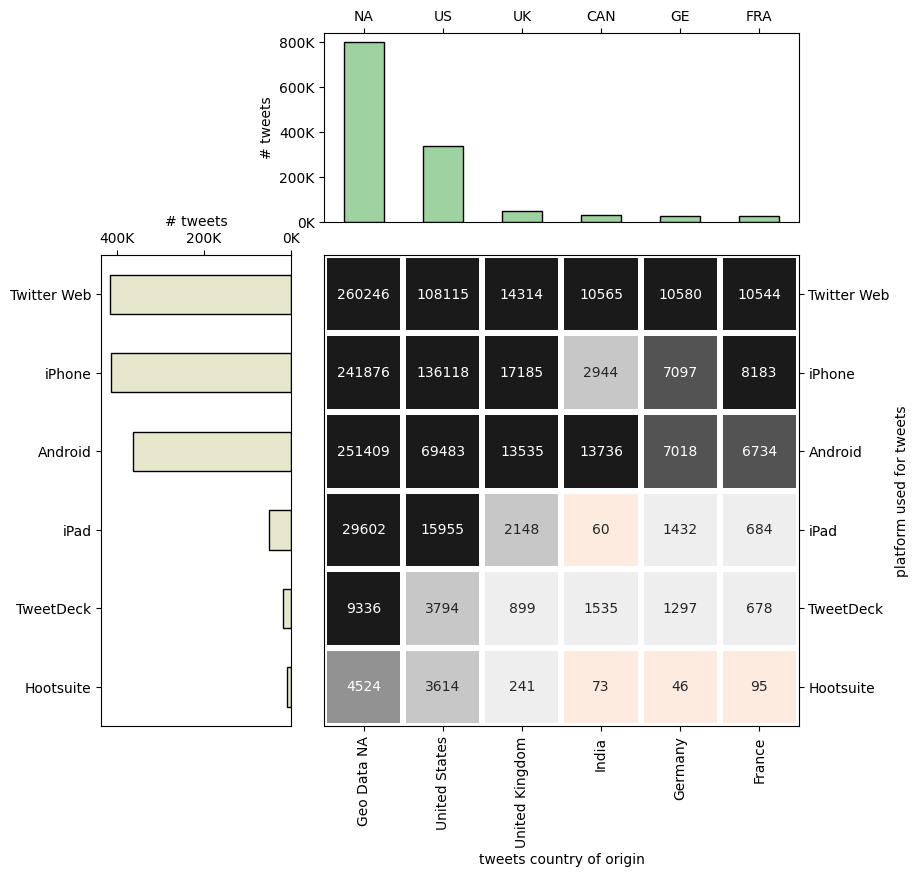

In [ ]:
source_df=pd.concat([tweets_biden[['source','tweet','country']].copy(),tweets_trump[['source','tweet','country']].copy()])
source_df['country'].replace({'United States of America':'United States'}, inplace=True)
source_df=source_df.fillna('Geo Data NA')
source_df=source_df.drop_duplicates()

sources=pd.DataFrame(source_df.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources=sources.reset_index()
sourceslst=sources.source.to_list()

country=pd.DataFrame(source_df.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country=country.reset_index()
countrylst=country.country.to_list()

platXtab=pd.DataFrame(source_df.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

fig, ax=plt.subplots(2,2, figsize=(9,9),
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap1(platXtab.loc[sourceslst,countrylst], hm_ax)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('platform used for tweets')
hm_ax.set_yticklabels(('Twitter Web','iPhone','Android','iPad','TweetDeck','Hootsuite'), rotation=0)

bar_ax = ax[0,1]
platXtab.loc[sourceslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_xticklabels(('NA', 'US', 'UK', 'CAN', 'GE','FRA'), rotation=0)
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# tweets')

barh_ax = ax[1,0]
platXtab.loc[sourceslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[2],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_yticklabels(('Hootsuite','TweetDeck','iPad','Android','iPhone','Twitter Web'), rotation=0)
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')
plt.show()

In [ ]:
%%time
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([tweets_biden[['tweet','country']].copy(),tweets_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)


<timed exec>:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





CPU times: user 48.1 s, sys: 381 ms, total: 48.5 s
Wall time: 55.5 s


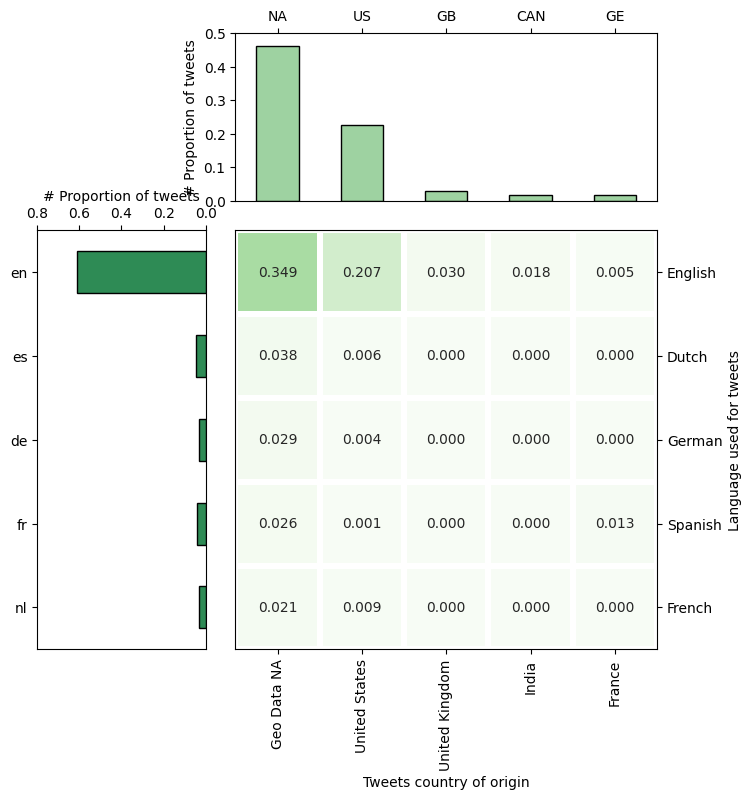

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure with specific subplots layout
fig, ax = plt.subplots(2, 2, figsize=(8, 8),
                       gridspec_kw={'height_ratios': [2, 5], 'width_ratios': [2, 5],
                                    'wspace': 0.1, 'hspace': 0.1})

# Hide the top-left axis
hide_ax = ax[0, 0]
hide_ax.axis('off')

# Heatmap in the bottom-right subplot
hm_ax = ax[1, 1]
draw_heatmap2(langXtab.loc[langslst, countrylst], hm_ax)
hm_ax.set_yticklabels(('English', 'Dutch', 'German', 'Spanish', 'French'), rotation=0)
hm_ax.set_xlabel('Tweets country of origin')
hm_ax.set_ylabel('Language used for tweets')

# Bar chart in the top-right subplot
bar_ax = ax[0, 1]
langXtab.loc[langslst, countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1], **barstyle)
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")

# Ensure tick labels match tick positions; adjust to match your data's tick count
bar_ax.set_xticks(range(5))  # Assuming 5 ticks; adjust this if needed
bar_ax.set_xticklabels(('NA', 'US', 'GB', 'CAN', 'GE'), rotation=0)  # Updated to 5 labels
bar_ax.set_ylim([0, 0.5])
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# Proportion of tweets')

# Horizontal bar chart in the bottom-left subplot
barh_ax = ax[1, 0]
langXtab.loc[langslst, countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[5], **barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.set_xlim([0.8, 0])
barh_ax.set_xlabel('# Proportion of tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(langslst[::-1], rotation=0)

# Display the plot
plt.show()


In [ ]:
# Identify the common UserId's in both datasets and create tables for feed visualisation
common_ids=np.intersect1d(tweets_biden.user_id, tweets_trump.user_id)
unique_b=tweets_biden[~tweets_biden.user_id.isin(common_ids)].copy()
common_b=tweets_biden[tweets_biden.user_id.isin(common_ids)].copy()
unique_t=tweets_trump[~tweets_trump.user_id.isin(common_ids)].copy()
common_t=tweets_trump[tweets_trump.user_id.isin(common_ids)].copy()

common_df=pd.concat([common_b,common_t])
common_df=common_df.drop_duplicates()

# Create columns for visualiation
unique_b['usertype'] = 'Biden'
unique_t['usertype'] = 'Trump'
common_df['usertype'] = 'Both'

# Narrow down data
cont_df=pd.concat([unique_b[['tweet','continent','usertype']].copy(),
                   unique_t[['tweet','continent','usertype']].copy(),
                   common_df[['tweet','continent','usertype']].copy()])

# Label NA Geo Data
cont_df=cont_df.fillna('Geo Data NA')

# Calculate tweet counts for each usertype and continuent
usertype=pd.DataFrame(cont_df.groupby(['usertype'])['tweet'].count().sort_values(ascending=False))
usertype=usertype.reset_index()
userlst=usertype.usertype.tolist()

continent=pd.DataFrame(cont_df.groupby(['continent'])['tweet'].count().sort_values(ascending=False)[:6])
continent=continent.reset_index()
contlst=continent.continent.to_list()

# Create crosstab to feed heatmap
contXtab=pd.crosstab(cont_df.continent, cont_df.usertype)

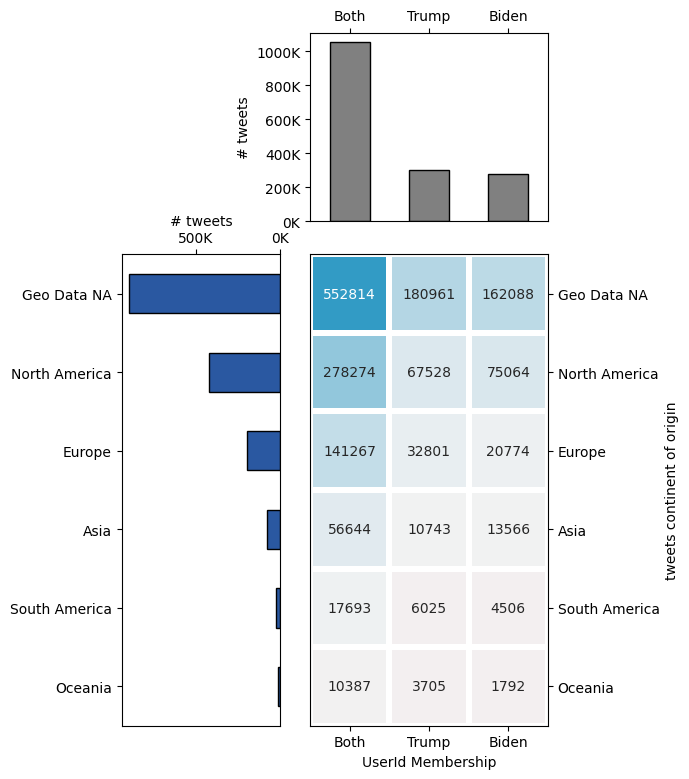

In [ ]:

fig, ax=plt.subplots(2,2, figsize=(5.5,9),
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,3], 'wspace':0.15, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap3(contXtab.loc[contlst,userlst], hm_ax)
hm_ax.set_xlabel('UserId Membership')
hm_ax.set_ylabel('tweets continent of origin')

bar_ax = ax[0,1]
contXtab.loc[contlst,userlst].sum().plot.bar(ax=bar_ax, color=barcolors[7],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_ylabel('# tweets')
bar_ax.set_xlabel('')

barh_ax = ax[1,0]
contXtab.loc[contlst,userlst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[4],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')

plt.show()

In [ ]:
# Identify common tweet creation dates
common_creat=np.intersect1d(tweets_biden.created_at_r, tweets_trump.created_at_r)

# Mask out data to ensure common lenth arrays to feed visualisation
cnt_tbiden=tweets_biden[tweets_biden.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_ttrump=tweets_trump[tweets_trump.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()

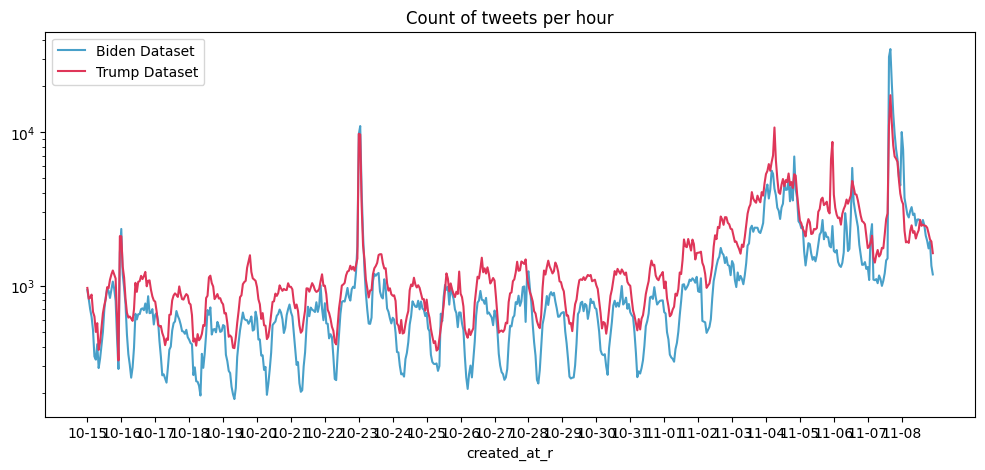

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Plot for Biden dataset
p6 = sns.lineplot(x=cnt_tbiden.index, y=cnt_tbiden.values, color=barcolors[3], label='Biden Dataset')
p6.set_title('Count of tweets per hour')

# Plot for Trump dataset
p6 = sns.lineplot(x=cnt_ttrump.index, y=cnt_ttrump.values, color=barcolors[6], label='Trump Dataset')

# Adjust x-ticks
p6.set_xticks(range(0, len(cnt_tbiden.index), 24))

# Set x-tick labels
p6.set_xticklabels(common_df['created_at'].dt.strftime('%m-%d').unique().tolist())

# Set y-scale to logarithmic
p6.set_yscale('log')

# Show the plot
plt.show()


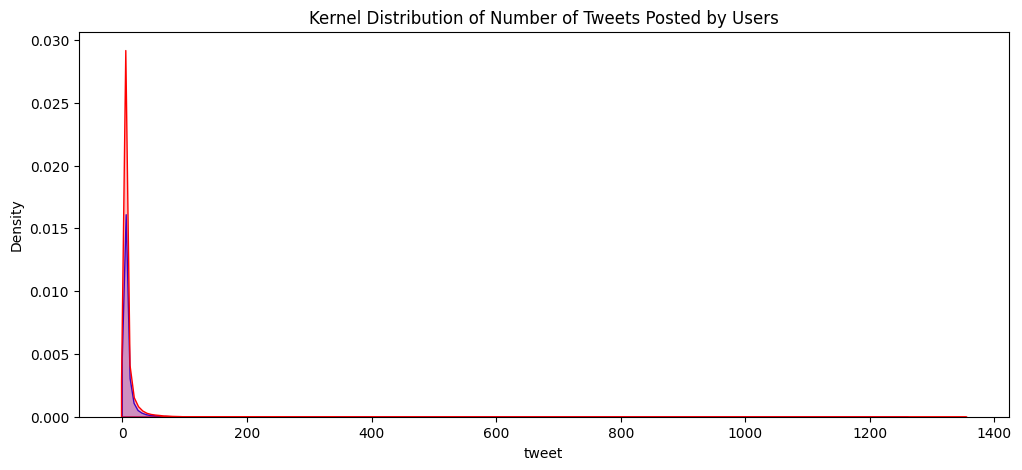

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
line_ax = ax
line_ax.set_title('Kernel Distribution of Number of Tweets Posted by Users')

# Plot the kernel density estimate for the Biden dataset
sns.kdeplot(
    data=tweets_biden.groupby(['user_id'])['tweet'].count(),
    fill=True, color='b', label='Biden Dataset', ax=line_ax
)

# Plot the kernel density estimate for the Trump dataset
sns.kdeplot(
    data=tweets_trump.groupby(['user_id'])['tweet'].count(),
    fill=True, color='r', label='Trump Dataset', ax=line_ax
)

# Display the plot
plt.show()


<ipython-input-71-140b25249b24>:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


<ipython-input-71-140b25249b24>:14: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-71-140b25249b24>:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


<ipython-input-71-140b25249b24>:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




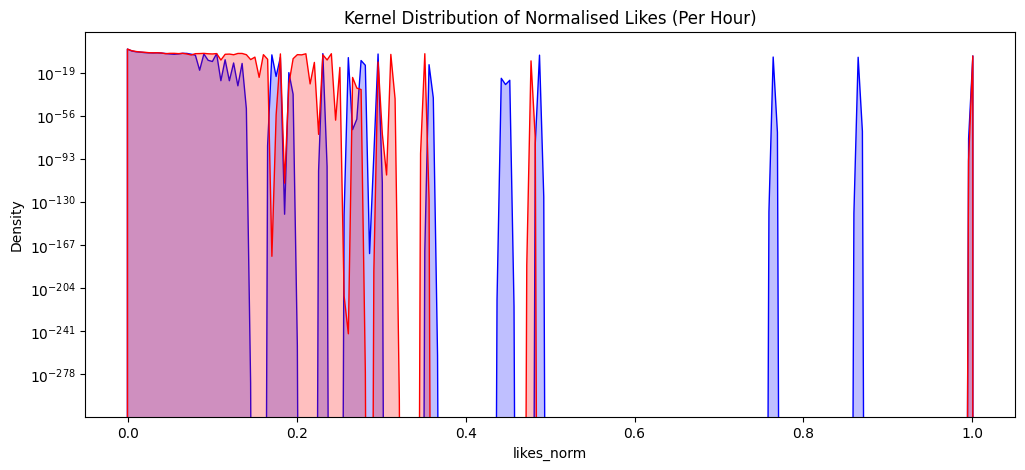

In [ ]:
# Check and create 'likes_norm' for tweets_biden
if 'likes_norm' not in tweets_biden.columns and 'likes' in tweets_biden.columns:
    tweets_biden['likes_norm'] = tweets_biden['likes'] / tweets_biden['likes'].max()

# Check and create 'likes_norm' for tweets_trump
if 'likes_norm' not in tweets_trump.columns and 'likes' in tweets_trump.columns:
    tweets_trump['likes_norm'] = tweets_trump['likes'] / tweets_trump['likes'].max()

# Now create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Normalised Likes (Per Hour)')
sns.kdeplot(tweets_biden['likes_norm'], bw=0.1, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['likes_norm'], bw=0.1, shade=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()


In [ ]:
# Obtain tweets only from data that has Geo Data from the US
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

In [ ]:
import nltk
nltk.download('wordnet', force=True)


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
import re
import unicodedata

# Ensure the 'stopwords' resource is downloaded
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Function to clean a single sentence
def clean1(sent):
    filtered_sent = ""
    stop_words = set(stopwords.words("english"))
    sent = (unicodedata.normalize("NFKD", sent)
            .encode("ascii", "ignore")
            .decode("utf-8", "ignore")
            .lower())
    sent = re.sub(r"#\S+|https?://\S+|[^a-zA-Z\s]", "", sent)
    words = sent.split()
    filtered_sent = " ".join(word for word in words if word not in stop_words)
    return filtered_sent

# Function to clean and lemmatize text
def clean2(text):
    wnl = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    text = (unicodedata.normalize("NFKD", text)
            .encode("ascii", "ignore")
            .decode("utf-8", "ignore")
            .lower())
    words = re.sub(r"[^\w\s]", "", text).split()
    return [wnl.lemmatize(word) for word in words if word not in stop_words]

# Applying the functions
# Assuming text1 and text2 are pandas Series
words1 = clean2("".join(str(text1.apply(clean1).tolist())))
words2 = clean2("".join(str(text2.apply(clean1).tolist())))

# Displaying the first 10 words of words1
print(words1[:10])


['en', 'dice', 'que', 'solo', 'se', 'preocupa', 'por', 'el', 'mismo', 'el']


In [ ]:
# Obtain top 10 Bi and Tri Ngrams from cleaned data
biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])

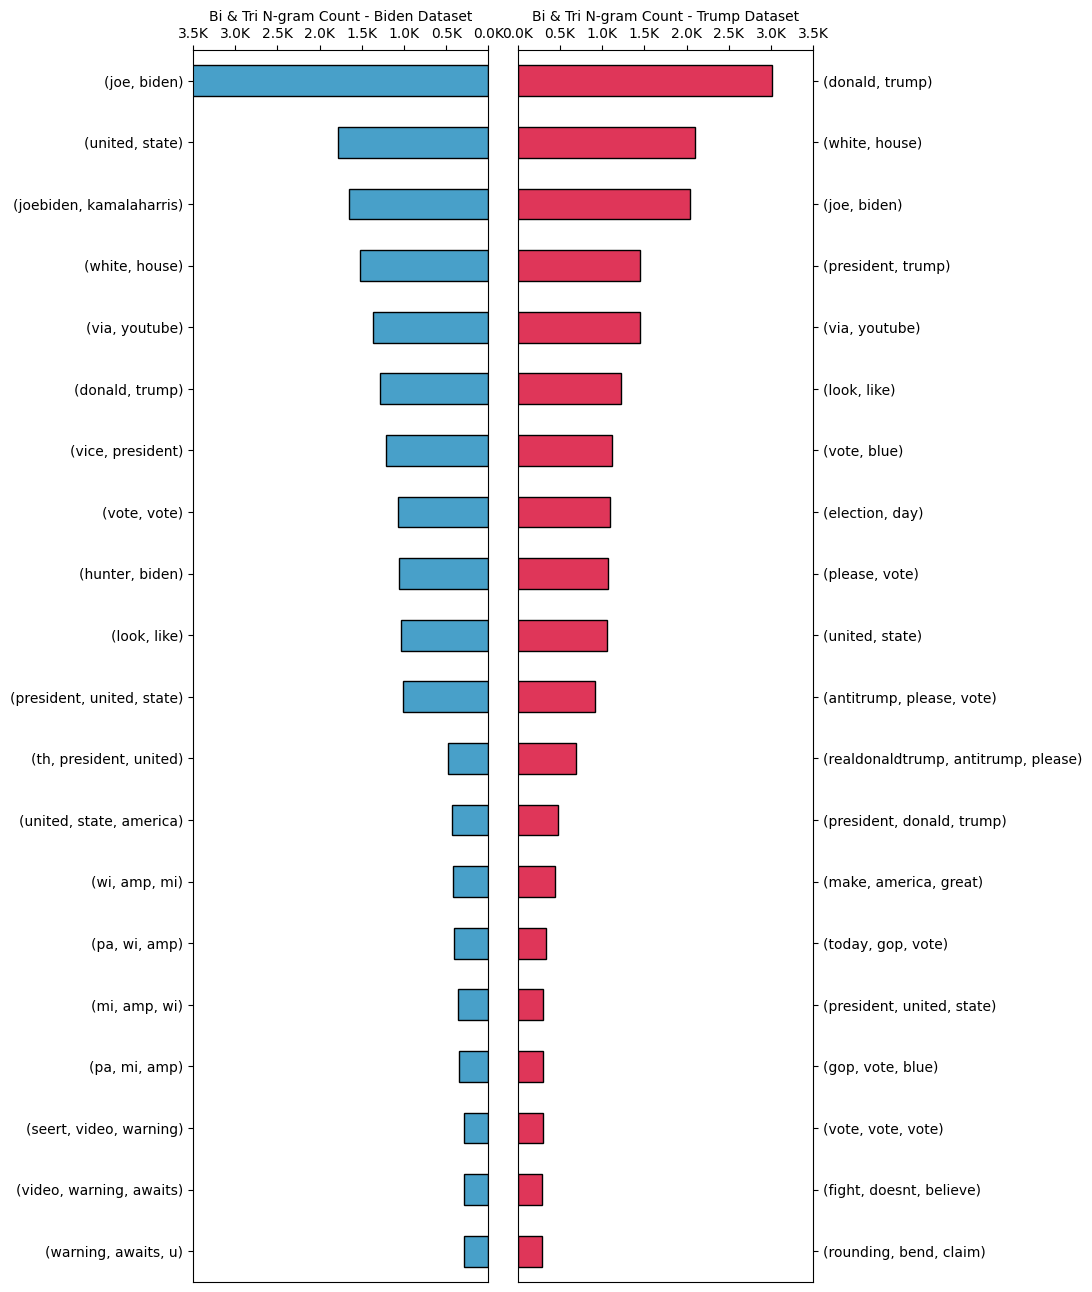

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(8,16),
                     gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
biden_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('Bi & Tri N-gram Count - Biden Dataset')
barh_ax.set_ylabel('')

barh_ax = ax[1]
trump_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_xlabel('Bi & Tri N-gram Count - Trump Dataset')
barh_ax.set_ylabel('')
plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# data processing/manipulation
pd.options.mode.chained_assignment = None
import re

# data visualization
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px

# stopwords, tokenizer, stemmer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

# spell correction, lemmatization
from textblob import TextBlob
from textblob import Word

# sklearn
from sklearn.model_selection import train_test_split

In [ ]:
trump_df = tweets_trump
biden_df = tweets_biden

In [ ]:
trump_df['tweet'].head(10)


,tweet
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...
1,"Usa 2020, Trump contro Facebook e Twitter: cop..."
2,"#Trump: As a student I used to hear for years,..."
3,2 hours since last tweet from #Trump! Maybe he...
4,You get a tie! And you get a tie! #Trump ‘s ra...
5,@CLady62 Her 15 minutes were over long time ag...
6,@richardmarx Glad u got out of the house! DICK...
7,@DeeviousDenise @realDonaldTrump @nypost There...
8,One of the single most effective remedies to e...
9,#Election2020 #Trump \n#FreedomOfSpeech https:...


In [ ]:
# Remove unneeded columns
trump_df = trump_df.drop(columns=['tweet_id','user_id','user_name','user_screen_name',
                                  'user_description','user_join_date','collected_at'])
biden_df = biden_df.drop(columns=['tweet_id','user_id','user_name','user_screen_name',
                                  'user_description','user_join_date','collected_at'])

In [ ]:
# Renaming columns
trump_df = trump_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets",
                                    "state": "State", "user_followers_count": "Followers"})
biden_df = biden_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets",
                                    "state": "State", "user_followers_count": "Followers"})

In [ ]:
# Update United States country name for consistency
d = {"United States of America":"United States"}
trump_df['country'].replace(d, inplace=True)
biden_df['country'].replace(d, inplace=True)

<ipython-input-82-195b57dbbdb1>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-82-195b57dbbdb1>:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

In [ ]:
trump_df = trump_df.loc[trump_df['country'] == "United States"]
biden_df = biden_df.loc[biden_df['country'] == "United States"]

In [ ]:
# Drop null rows
trump_df = trump_df.dropna()
biden_df = biden_df.dropna()

In [ ]:
to_remove = r'\d+|http?\S+|[^A-Za-z0-9]+'
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Function to preprocess tweet
def clean_tweet(tweet, stem=False, lemmatize=False):

    # Make all text lowercase
    tweet = tweet.lower()

    # Remove links, special characters, punctuation, numbers, etc.
    tweet = re.sub(to_remove, ' ', tweet)

    filtered_tweet = []
    words = word_tokenize(tweet)

    # Remove stopwords and stem
    for word in words:
        if not word in stop_words:
            if stem:
                filtered_tweet.append(ps.stem(word))
            elif lemmatize:
                filtered_tweet.append(Word(word).lemmatize())
            else:
                filtered_tweet.append(word)

    return filtered_tweet

In [ ]:
import nltk
nltk.download('punkt')
import nltk

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import nltk
nltk.download('punkt_tab')
trump_df['tweetNew'] = trump_df.tweet.apply(lambda x: clean_tweet(x))
biden_df['tweetNew'] = biden_df.tweet.apply(lambda x: clean_tweet(x))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Looking at 5 trump tweets after filtering
trump_df['tweetNew'].head()

,tweetNew
2,"[trump, student, used, hear, years, ten, years..."
4,"[get, tie, get, tie, trump, rally, iowa]"
11,"[nypost, censorship, censored, twitter, manipu..."
12,"[trump, presidenttrump, trump, landslidevictor..."
22,"[trump, nobody, likes, tell, farmers, better, ..."


In [ ]:
def sentiment_analysis(df):

    # Determine polarity and subjectivity
    df['Polarity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)

    # Classify overall sentiment
    df.loc[df.Polarity > 0,'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0,'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0,'Sentiment'] = 'negative'

    return df[['tweet','tweetNew','Polarity','Subjectivity','Sentiment']].head()

In [ ]:
# Perform sentiment analysis on trump_df
sentiment_analysis(trump_df)

,tweet,tweetNew,Polarity,Subjectivity,Sentiment
2,"#Trump: As a student I used to hear for years,...","[trump, student, used, hear, years, ten, years...",0.333333,0.333333,positive
4,You get a tie! And you get a tie! #Trump ‘s ra...,"[get, tie, get, tie, trump, rally, iowa]",0.000000,0.000000,neutral
11,"In 2020, #NYPost is being #censorship #CENSORE...","[nypost, censorship, censored, twitter, manipu...",-0.148810,0.678571,negative
12,#Trump #PresidentTrump #Trump2020LandslideVict...,"[trump, presidenttrump, trump, landslidevictor...",0.500000,0.750000,positive
22,"#Trump: Nobody likes to tell you this, but som...","[trump, nobody, likes, tell, farmers, better, ...",0.261905,0.595238,positive


In [ ]:
# Perform sentiment analysis on biden_df
sentiment_analysis(biden_df)

,tweet,tweetNew,Polarity,Subjectivity,Sentiment
6,"In 2020, #NYPost is being #censorship #CENSORE...","[nypost, censorship, censored, twitter, manipu...",-0.148810,0.678571,negative
17,"Comments on this? ""Do Democrats Understand how...","[comments, democrats, understand, ruthless, ch...",-1.000000,1.000000,negative
22,Twitter is doing everything they can to help D...,"[twitter, everything, help, democrats, win, el...",0.175000,0.522222,positive
25,@RealJamesWoods #BidenCrimeFamily #JoeBiden #H...,"[realjameswoods, bidencrimefamily, joebiden, h...",0.000000,0.000000,neutral
29,Come on @ABC PLEASE DO THE RIGHT THING. Move t...,"[come, abc, please, right, thing, move, biden,...",0.078571,0.178571,positive


Trump Tweet Sentiment Breakdown


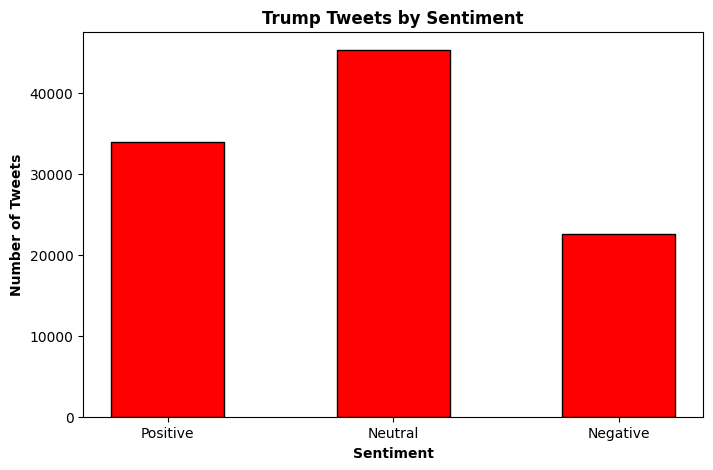

In [ ]:
# Overall sentiment breakdown - Trump
print("Trump Tweet Sentiment Breakdown")

trump_positive = len(trump_df.loc[trump_df.Sentiment=='positive'])
trump_neutral = len(trump_df.loc[trump_df.Sentiment=='neutral'])
trump_negative = len(trump_df.loc[trump_df.Sentiment=='negative'])

# Graphing the number of trump tweets by sentiment
data_t = {'Positive':trump_positive,'Neutral':trump_neutral,'Negative':trump_negative}
sentiment_t = list(data_t.keys())
num_tweets_t = list(data_t.values())

plt.figure(figsize = (8, 5))

plt.bar(sentiment_t, num_tweets_t, color ='red', width = 0.5, edgecolor='black',)

plt.xlabel("Sentiment", fontweight ='bold')
plt.ylabel("Number of Tweets", fontweight ='bold')
plt.title("Trump Tweets by Sentiment", fontweight ='bold')
plt.show()

Biden Tweet Sentiment Breakdown


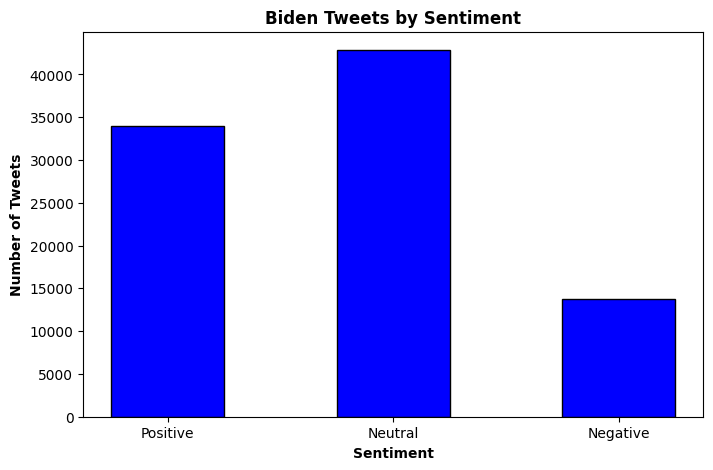

In [ ]:
# Overall sentiment breakdown - Biden
print("Biden Tweet Sentiment Breakdown")

biden_positive = len(biden_df.loc[biden_df.Sentiment=='positive'])
biden_neutral = len(biden_df.loc[biden_df.Sentiment=='neutral'])
biden_negative = len(biden_df.loc[biden_df.Sentiment=='negative'])

# Graphing the number of biden tweets by sentiment
data_b = {'Positive':biden_positive,'Neutral':biden_neutral,'Negative':biden_negative}
sentiment_b = list(data_b.keys())
num_tweets_b = list(data_b.values())

plt.figure(figsize = (8, 5))

plt.bar(sentiment_b, num_tweets_b, color ='blue', width = 0.5, edgecolor='black')

plt.xlabel("Sentiment", fontweight ='bold')
plt.ylabel("Number of Tweets", fontweight ='bold')
plt.title("Biden Tweets by Sentiment", fontweight ='bold')
plt.show()

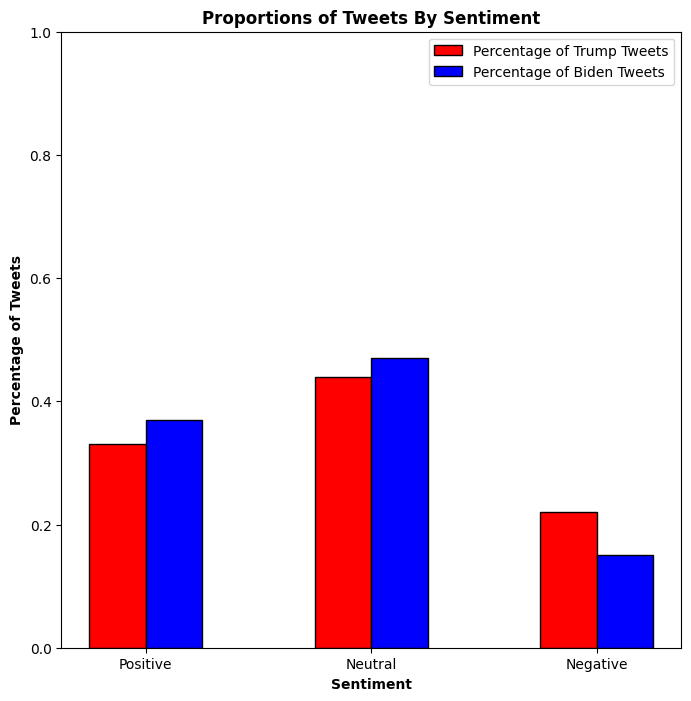

In [ ]:
# Calculate relative percentages by sentiment - Trump
total_tweets_t = len(trump_df.Sentiment)
prop_tweets_t = list(map(lambda x: round(x/total_tweets_t,2), num_tweets_t))

# Calculate relative percentages by sentiment - Biden
total_tweets_b = len(biden_df.Sentiment)
prop_tweets_b = list(map(lambda x: round(x/total_tweets_b,2), num_tweets_b))

# Graphing relative percentages of both trump and biden tweets
bar_width = 0.25
plt.subplots(figsize=(8,8))

br1 = np.arange(3)
br2 = [x + bar_width for x in br1]

t = plt.bar(br1, prop_tweets_t, color ='r', width = bar_width,
            edgecolor ='black', label ='Trump')
b = plt.bar(br2, prop_tweets_b, color ='b', width = bar_width,
            edgecolor ='black', label ='Biden')

plt.xlabel('Sentiment',fontweight ='bold')
plt.ylabel('Percentage of Tweets',fontweight ='bold')
plt.xticks([r + bar_width/2 for r in range(3)],['Positive','Neutral','Negative'])
plt.legend([t,b],['Percentage of Trump Tweets','Percentage of Biden Tweets'])
plt.ylim(0.0, 1.0)
plt.title('Proportions of Tweets By Sentiment',fontweight ='bold')

plt.show()

In [ ]:
# Function to return a string of all words in all tweets
def get_all_tweets(df,by_sentiment=False,sentiment="positive"):
    words = ' '.join(df['tweetNew'].apply(lambda x: ' '.join(x)))
    return words

In [ ]:
# Create word strings
words_trump = get_all_tweets(trump_df)
words_biden = get_all_tweets(biden_df)

# Tokenize word strings
tokens_trump = word_tokenize(words_trump)
tokens_biden = word_tokenize(words_biden)

# Function to generate word cloud
def create_wordcloud(words):

    # create wordcloud
    wordcloud = WordCloud(max_font_size=200, max_words=200,
                          background_color="white").generate(words)

    # display the generated image
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


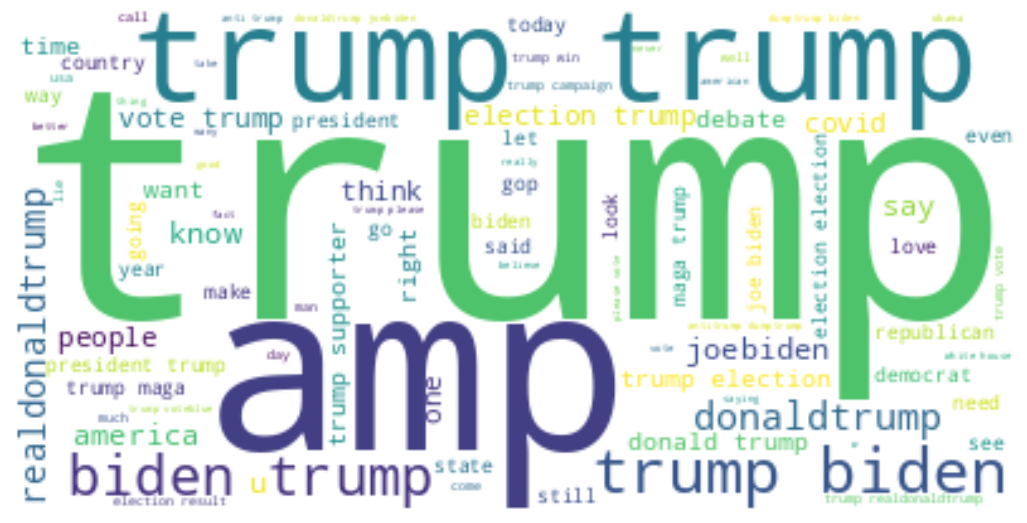

In [ ]:
# Generate word cloud of trump tweets
create_wordcloud(words_trump)

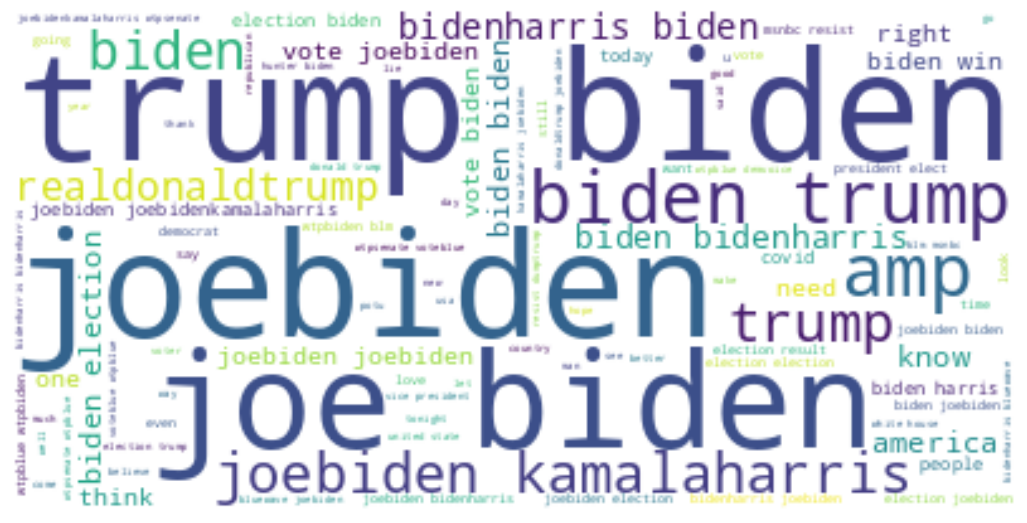

In [ ]:
# Generate word cloud of biden tweets
create_wordcloud(words_biden)

In [ ]:
# Ensure 'Polarity' column is numeric, coerce errors to NaN and drop them
trump_df["Polarity"] = pd.to_numeric(trump_df["Polarity"], errors='coerce')

# Drop rows where 'Polarity' is NaN if any, to avoid mean calculation issues
trump_df = trump_df.dropna(subset=["Polarity"])

# Group by state and calculate the mean polarity
trump_state_polarity = trump_df.groupby("State", as_index=False)["Polarity"].mean()

# Plotting
fig = px.bar(trump_state_polarity, x="State", y="Polarity",
             title="<b>Average Polarity of Trump-Related Tweets by State</b>")
fig.update_traces(marker=dict(color="red"), selector=dict(type="bar"),
                  marker_line_color='black', marker_line_width=0.8, opacity=0.6)
fig.show()


In [ ]:
# Ensure 'Polarity' column is numeric, coerce errors to NaN and drop them
biden_df["Polarity"] = pd.to_numeric(biden_df["Polarity"], errors='coerce')

# Drop rows where 'Polarity' is NaN if any, to avoid mean calculation issues
biden_df = biden_df.dropna(subset=["Polarity"])

# Group by state and calculate the mean polarity
biden_state_polarity = biden_df.groupby("State", as_index=False)["Polarity"].mean()

# Plotting
fig = px.bar(biden_state_polarity, x="State", y="Polarity",
             title="<b>Average Polarity of Biden-Related Tweets by State</b>")
fig.update_traces(marker=dict(color="blue"), selector=dict(type="bar"),
                  marker_line_color='black', marker_line_width=0.8, opacity=0.6)
fig.show()


In [ ]:
import pandas as pd
from textblob import TextBlob

def sentiment_analysis_statewise(df):
    # Determine polarity and subjectivity
    df['Polarity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)

    # Classify overall sentiment
    df.loc[df.Polarity > 0, 'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0, 'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0, 'Sentiment'] = 'negative'

    # Calculate state-wise sentiment analysis percentages
    sentiment_counts = df.groupby('State')['Sentiment'].value_counts(normalize=True).unstack(fill_value=0) * 100

    # Print the percentage of each sentiment by state
    print("State-wise Sentiment Analysis Percentage:")
    print(sentiment_counts)


In [ ]:
sentiment_analysis_statewise(trump_df)

State-wise Sentiment Analysis Percentage:
Sentiment              negative    neutral   positive
State                                                
Alabama               24.367089  37.025316  38.607595
Alaska                20.430108  50.537634  29.032258
Arizona               22.149254  41.671642  36.179104
Arkansas              24.285714  51.428571  24.285714
California            21.957174  46.137023  31.905803
Colorado              25.030012  42.436975  32.533013
Connecticut           21.538462  42.051282  36.410256
Delaware               6.666667  80.000000  13.333333
District of Columbia  20.061175  47.959076  31.979749
Florida               17.859187  52.175157  29.965655
Georgia               17.839196  45.979899  36.180905
Hawaii                25.750000  44.250000  30.000000
Idaho                 27.129338  33.123028  39.747634
Illinois              25.286663  41.500704  33.212633
Indiana               20.857474  57.473928  21.668598
Iowa                  23.668639  46.7455

In [ ]:
sentiment_analysis_statewise(biden_df)


State-wise Sentiment Analysis Percentage:
Sentiment              negative    neutral   positive
State                                                
Alabama               15.358362  48.464164  36.177474
Alaska                15.079365  38.888889  46.031746
Arizona               16.621548  43.692474  39.685977
Arkansas              17.333333  33.333333  49.333333
California            15.393759  46.050520  38.555721
Colorado              16.144201  50.313480  33.542320
Connecticut           17.218543  50.331126  32.450331
Delaware               5.747126  40.229885  54.022989
District of Columbia  13.470613  51.623052  34.906335
Florida               12.997940  53.021978  33.980082
Georgia               13.724008  47.410208  38.865784
Hawaii                18.483412  42.180095  39.336493
Idaho                 20.000000  44.848485  35.151515
Illinois              15.813702  46.709992  37.476307
Indiana               11.926606  62.232416  25.840979
Iowa                  12.857143  45.0000

In [ ]:
tweets_df = tweets_trump
# Step 1: Convert 'created_at' to datetime if not already
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

# Step 2: Extract hour and minute to get precise timing
tweets_df['hour_minute'] = tweets_df['created_at'].dt.strftime('%H:%M')

# Step 3: Calculate average engagement by hour and minute
minute_engagement = tweets_df.groupby('hour_minute')[['retweet_count', 'likes']].mean().reset_index()

# Step 4: Find the specific minute with the highest average engagement
optimal_minute_retweets = minute_engagement.loc[minute_engagement['retweet_count'].idxmax()]
optimal_minute_likes = minute_engagement.loc[minute_engagement['likes'].idxmax()]

# Display optimal times and engagement
print("For Trump")
print(f"Optimal time to tweet is: {optimal_minute_retweets['hour_minute']}")

tweets_df = tweets_biden
# Step 1: Convert 'created_at' to datetime if not already
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

# Step 2: Extract hour and minute to get precise timing
tweets_df['hour_minute'] = tweets_df['created_at'].dt.strftime('%H:%M')

# Step 3: Calculate average engagement by hour and minute
minute_engagement = tweets_df.groupby('hour_minute')[['retweet_count', 'likes']].mean().reset_index()

# Step 4: Find the specific minute with the highest average engagement
optimal_minute_retweets = minute_engagement.loc[minute_engagement['retweet_count'].idxmax()]
optimal_minute_likes = minute_engagement.loc[minute_engagement['likes'].idxmax()]

# Display optimal times and engagement
print("For Biden")
print(f"Optimal time to tweet is: {optimal_minute_retweets['hour_minute']}")


For Trump
Optimal time to tweet is: 16:31
For Biden
Optimal time to tweet is: 22:34


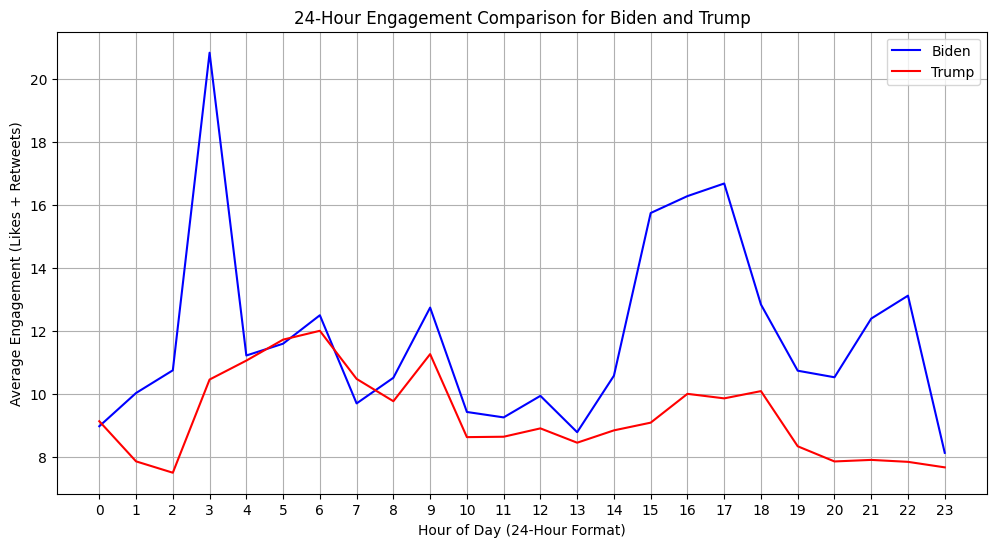

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_24hr_comparison(tweets_biden, tweets_trump):
    # Ensure 'created_at' is datetime
    tweets_biden['created_at'] = pd.to_datetime(tweets_biden['created_at'])
    tweets_trump['created_at'] = pd.to_datetime(tweets_trump['created_at'])

    # Extract hour and calculate engagement (likes + retweets)
    tweets_biden['hour'] = tweets_biden['created_at'].dt.hour
    tweets_trump['hour'] = tweets_trump['created_at'].dt.hour
    tweets_biden['engagement'] = tweets_biden['likes'] + tweets_biden['retweet_count']
    tweets_trump['engagement'] = tweets_trump['likes'] + tweets_trump['retweet_count']

    # Group by hour and calculate the mean engagement per hour
    biden_engagement = tweets_biden.groupby('hour')['engagement'].mean()
    trump_engagement = tweets_trump.groupby('hour')['engagement'].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(biden_engagement.index, biden_engagement.values, color='blue', label='Biden')
    plt.plot(trump_engagement.index, trump_engagement.values, color='red', label='Trump')

    # Labels and legend
    plt.xlabel('Hour of Day (24-Hour Format)')
    plt.ylabel('Average Engagement (Likes + Retweets)')
    plt.title('24-Hour Engagement Comparison for Biden and Trump')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, 24))  # Display all hours

    plt.show()

# Usage example
plot_24hr_comparison(tweets_biden, tweets_trump)


In [ ]:
import pandas as pd
from textblob import TextBlob

def sentiment_analysis_statewise1(df):
    # Ensure the column name containing the tweet text is correct
    tweet_column = 'tweet'  # Replace with the actual column name containing tweet text

    # Ensure that the 'State' column exists
    if 'State' not in df.columns:
        print("Error: DataFrame does not contain a 'State' column.")
        return

    # Determine polarity and subjectivity
    df['Polarity'] = df[tweet_column].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['Subjectivity'] = df[tweet_column].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # Classify overall sentiment
    df.loc[df.Polarity > 0, 'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0, 'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0, 'Sentiment'] = 'negative'

    # Calculate state-wise sentiment analysis percentages
    sentiment_counts = df.groupby('State')['Sentiment'].value_counts(normalize=True).unstack(fill_value=0) * 100

    # Reshape and find the sentiment with the highest percentage for each state
    sentiment_summary = sentiment_counts.stack().reset_index(name='Percentage')
    max_sentiments = sentiment_summary.loc[sentiment_summary.groupby('State')['Percentage'].idxmax()]

    # Format the output
    max_sentiments['Formatted'] = max_sentiments.apply(
        lambda row: f"{row['State']} {row['Sentiment'].capitalize()} {row['Percentage']:.2f}%",
        axis=1
    )

    # Print the formatted output
    for sentiment in max_sentiments['Formatted']:
        print(sentiment)

# Usage example
# sentiment_analysis_statewise(tweets_trump)  # Ensure the correct DataFrame is passed here


In [ ]:
sentiment_analysis_statewise1(trump_df)

Alabama Positive 40.51%
Alaska Neutral 49.46%
Arizona Neutral 39.82%
Arkansas Neutral 50.00%
California Neutral 44.01%
Colorado Neutral 40.94%
Connecticut Positive 42.05%
Delaware Neutral 80.00%
District of Columbia Neutral 46.03%
Florida Neutral 50.56%
Georgia Neutral 43.93%
Hawaii Neutral 41.75%
Idaho Positive 41.32%
Illinois Neutral 38.68%
Indiana Neutral 55.74%
Iowa Neutral 40.83%
Kansas Neutral 48.91%
Kentucky Neutral 45.15%
Louisiana Positive 39.18%
Maine Positive 40.00%
Maryland Positive 37.56%
Massachusetts Neutral 40.22%
Michigan Positive 43.65%
Minnesota Neutral 35.99%
Mississippi Positive 46.25%
Missouri Neutral 40.89%
Montana Negative 39.39%
Nebraska Positive 44.53%
Nevada Neutral 41.23%
New Hampshire Positive 52.00%
New Jersey Neutral 41.56%
New Mexico Neutral 49.38%
New York Neutral 41.36%
North Carolina Neutral 39.70%
North Dakota Neutral 46.15%
Ohio Positive 38.40%
Oklahoma Neutral 43.99%
Oregon Positive 42.76%
Pennsylvania Neutral 39.19%
Puerto Rico Neutral 47.11%
Rhod

In [ ]:
sentiment_analysis_statewise1(biden_df)

Alabama Neutral 46.42%
Alaska Positive 42.86%
Arizona Neutral 42.39%
Arkansas Positive 48.00%
California Neutral 44.07%
Colorado Neutral 48.67%
Connecticut Neutral 48.34%
Delaware Positive 57.47%
District of Columbia Neutral 49.41%
Florida Neutral 51.91%
Georgia Neutral 45.63%
Hawaii Neutral 41.71%
Idaho Neutral 44.24%
Illinois Neutral 44.41%
Indiana Neutral 60.70%
Iowa Positive 44.29%
Kansas Neutral 45.52%
Kentucky Neutral 44.38%
Louisiana Neutral 41.95%
Maine Positive 50.00%
Maryland Neutral 42.75%
Massachusetts Neutral 46.22%
Michigan Neutral 45.18%
Minnesota Neutral 45.22%
Mississippi Positive 41.75%
Missouri Neutral 42.11%
Montana Positive 46.55%
Nebraska Neutral 50.94%
Nevada Neutral 44.59%
New Hampshire Positive 43.33%
New Jersey Positive 42.07%
New Mexico Neutral 47.93%
New York Neutral 43.26%
North Carolina Positive 41.96%
North Dakota Positive 45.16%
Ohio Neutral 57.27%
Oklahoma Neutral 46.00%
Oregon Positive 42.19%
Pennsylvania Neutral 43.49%
Puerto Rico Neutral 57.52%
Rhode

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sentiment_bar_graph(df):
    # Ensure the column name containing the tweet text is correct
    tweet_column = 'tweet'  # Replace with the actual column name containing tweet text

    # Ensure that the 'State' column exists
    if 'State' not in df.columns:
        print("Error: DataFrame does not contain a 'State' column.")
        return

    # Determine polarity and subjectivity
    df['Polarity'] = df[tweet_column].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['Subjectivity'] = df[tweet_column].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # Classify overall sentiment
    df.loc[df.Polarity > 0, 'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0, 'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0, 'Sentiment'] = 'negative'

    # Calculate state-wise sentiment analysis percentages
    sentiment_counts = df.groupby('State')['Sentiment'].value_counts(normalize=True).unstack(fill_value=0) * 100

    # Reshape and find the sentiment with the highest percentage for each state
    sentiment_summary = sentiment_counts.stack().reset_index(name='Percentage')
    max_sentiments = sentiment_summary.loc[sentiment_summary.groupby('State')['Percentage'].idxmax()]

    # Map colors based on sentiment
    color_map = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}
    max_sentiments['Color'] = max_sentiments['Sentiment'].map(color_map)

    # Plot bar graph
    plt.figure(figsize=(12, 6))
    plt.bar(max_sentiments['State'], max_sentiments['Percentage'], color=max_sentiments['Color'])

    # Customize the graph
    plt.xticks(rotation=90)
    plt.xlabel('State')
    plt.ylabel('Percentage')
    plt.title('Highest Sentiment Percentage by State')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add labels for bars
    for index, row in max_sentiments.iterrows():
        plt.text(row['State'], row['Percentage'] + 1, f"{row['Percentage']:.2f}%", ha='center', fontsize=8)

    # Display the graph
    plt.tight_layout()
    plt.show()

# Example usage
#   # Ensure the correct DataFrame is passed here


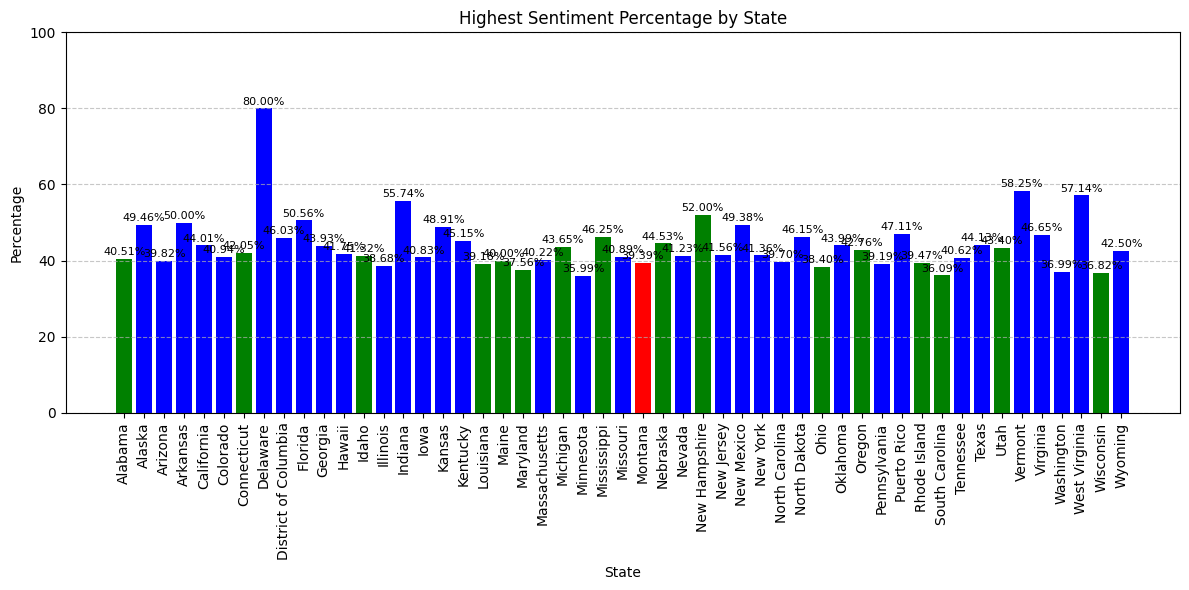

In [ ]:
plot_sentiment_bar_graph(trump_df)

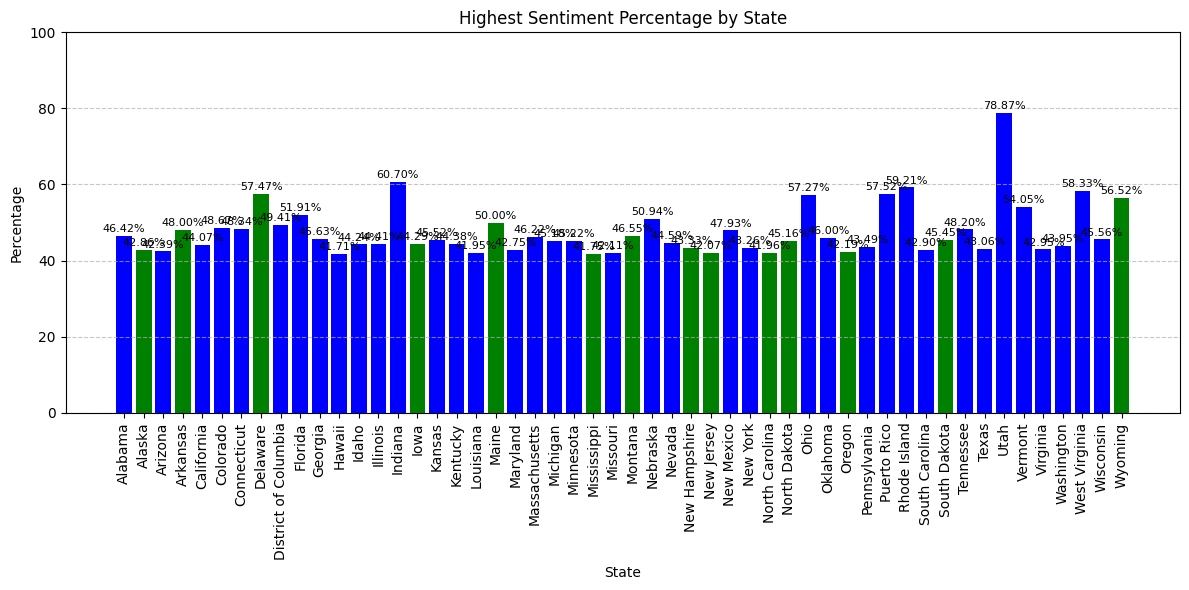

In [ ]:
plot_sentiment_bar_graph(biden_df)

In [ ]:
trump_df['candidate'] = 'trump'

# biden dataframe
biden_df['candidate'] = 'biden'

data = pd.concat([trump_df, biden_df])
# Group the data by 'candidate' and count the
# number of tweets for each candidate
# Group the data by 'candidate' and count the
# number of tweets for each candidate
tweets_count = data.groupby('candidate')['tweet'].count().reset_index()

# Interactive bar chart
fig = px.bar(tweets_count, x='candidate', y='tweet', color='candidate',
color_discrete_map={'Trump': 'pink', 'Biden': 'blue'},
labels={'candidate': 'Candidates', 'tweet': 'Number of Tweets'},
title='Tweets for Candidates')

# Update the layout with a black theme
fig.update_layout(plot_bgcolor='black',
paper_bgcolor='black', font_color='white')

# Show the chart
fig.show()

In [ ]:
# Interactive bar chart
likes_comparison = data.groupby('candidate')['Likes'].sum().reset_index()
fig = px.bar(likes_comparison, x='candidate', y='Likes', color='candidate',
color_discrete_map={'Trump': 'blue', 'Biden': 'green'},
labels={'candidate': 'Candidate', 'likes': 'Total Likes'},
title='Comparison of Likes')

# Update the layout with a black theme
fig.update_layout(plot_bgcolor='black',
paper_bgcolor='black', font_color='white')

# Show the chart
fig.show()

In [ ]:
def sentiment_analysis_perday(df):
    from textblob import TextBlob

    # Determine polarity and subjectivity
    df['Polarity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)

    # Classify overall sentiment
    df.loc[df.Polarity > 0, 'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0, 'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0, 'Sentiment'] = 'negative'

    # Calculate average polarity per day
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure the Date column is in datetime format
    avg_polarity_per_day = df.groupby('Date')['Polarity'].mean()

    # Print the average polarity per day
    print(avg_polarity_per_day)

    return df[['tweet', 'tweetNew', 'Polarity', 'Subjectivity', 'Sentiment']].head()
